In [1]:
import os
import pickle
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score

generic_dir = r'C:\Users\61407\mental-health-modelling\fNIRS Mental Workload\final_models\generic'
subject_dir = r'C:\Users\61407\mental-health-modelling\fNIRS Mental Workload\final_models\subject'
fnirs_data = r'C:\Users\61407\mental-health-modelling\data\fNIRS\bandpass_filtered_whole_data'

## Generic models 4-class predictions ##

In [2]:
generic_4class = {}
for folder in ['ML_10s_chunks_no_overlap',
               '1DCNN_10s_chunks_no_overlap',
               'ML_20s_chunks_no_overlap_51train_17test',
               'ML_20s_chunks_no_overlap_64train_4test',
               '1DCNN_20s_chunks_no_overlap_51train_17test',
               '1DCNN_20s_chunks_no_overlap_64train_4test']:
    folder_path = os.path.join(generic_dir, folder)
    files = [x for x in os.listdir(folder_path) if ('0_vs_2' not in x) & ('low_vs_high' not in x)]
    folder_predictions = {}
    for f in files:
        b = f.split('bucket')[1].split('_')[0]
        train = '75%' if '51train' in f else '94%'
        
        with open(os.path.join(folder_path, f), 'rb') as file:
            bucket = pickle.load(file) if 'ML' in folder else joblib.load(file)
            
        if 'ML' in f:
            val_scores = np.array([pipe_dict['rcv'].best_score_ for pipe, pipe_dict in bucket.items()])
            best_pipe = list(bucket.keys())[np.argmax(val_scores)]
            predictions = pd.concat({sub: pd.DataFrame([sub_dict['ytrue'], sub_dict['ypred']], 
                                                       index=['ytest','ypred']).T
                                    for sub, sub_dict in bucket[best_pipe]['predictions'].items()})
        else:
            predictions = pd.concat({sub: pd.DataFrame([sub_dict['ytest'].values, sub_dict['ypred_test']], 
                                                       index=['ytest','ypred']).T
                                    for sub, sub_dict in bucket['predictions'].items()})
        folder_predictions[b] = predictions
    generic_4class[f'{folder}_{train}'] = pd.concat(folder_predictions)

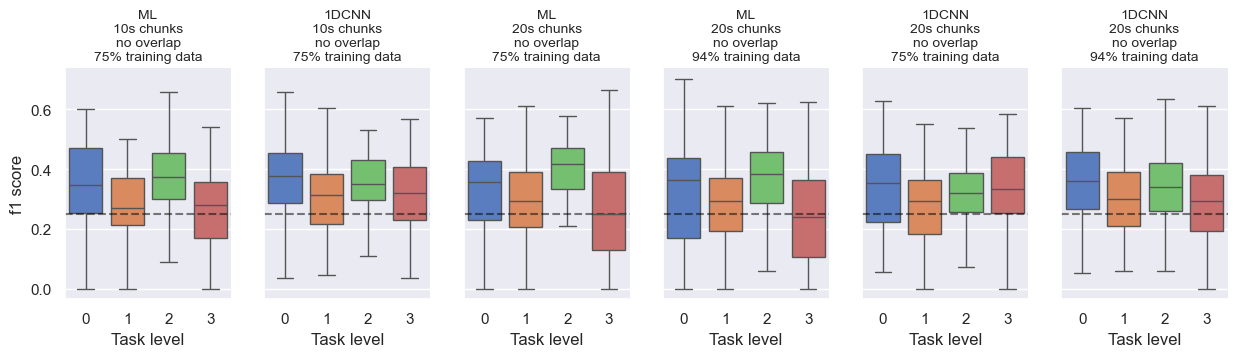

In [7]:
sns.set()
fig, ax = plt.subplots(nrows=1, ncols=6,
                       figsize=(15,3),
                       sharey=True)
sns.set_palette('muted')
for col, (folder, df) in enumerate(generic_4class.items()):
    architecture = folder.split('_')[0]
    chunk = folder.split('_')[1]
    overlap = folder.split('_')[3]
    train = folder.split('_')[-1]
    
    sub_groups = df.groupby(df.index.get_level_values(1))
    f1_all = []
    for sub in sub_groups.groups:
        sub_df = sub_groups.get_group(sub)
        f1 = f1_score(sub_df.ytest, sub_df.ypred, average=None)
        f1_all.append(f1)
    sns.boxplot(np.vstack(f1_all), ax=ax[col], showfliers=False)
    ax[col].set_title(f'{architecture}\n{chunk} chunks\n{overlap} overlap\n{train} training data', fontsize=10)
    ax[col].axhline(0.25, ls='--', color='black', alpha=0.5)
    ax[col].spines['top'].set_visible(False)
    ax[col].spines['right'].set_visible(False)
    ax[col].set_ylabel('f1 score') if col == 0 else None
    ax[col].set_xlabel('Task level')
fig.savefig('all_generic_4class.png', bbox_inches='tight')

## Generic models 2-class predictions ##

In [12]:
generic_2class = {}
for folder in ['ML_10s_chunks_no_overlap',
               '1DCNN_10s_chunks_no_overlap',
               'ML_20s_chunks_no_overlap_51train_17test',
               '1DCNN_20s_chunks_no_overlap_51train_17test',
              ]:
    folder_path = os.path.join(generic_dir, folder)
    files = [x for x in os.listdir(folder_path) if ('low_vs_high' in x)]
    
    folder_predictions = {}
    for f in files:
        b = f.split('bucket')[1].split('_')[0]
        train = '75%' if '51train' in f else '94%'

        with open(os.path.join(folder_path, f), 'rb') as file:
            bucket = pickle.load(file) if 'ML' in folder else joblib.load(file)

            if 'ML' in f:
                val_scores = np.array([pipe_dict['rcv'].best_score_ for pipe, pipe_dict in bucket.items()])
                best_pipe = list(bucket.keys())[np.argmax(val_scores)]
                predictions = pd.concat({sub: pd.DataFrame([sub_dict['ytrue'], sub_dict['ypred']], 
                                                           index=['ytest','ypred']).T
                                        for sub, sub_dict in bucket[best_pipe]['predictions'].items()})
            else:
                predictions = pd.concat({sub: pd.DataFrame([sub_dict['ytest'].values, sub_dict['ypred_test']], 
                                                           index=['ytest','ypred']).T
                                        for sub, sub_dict in bucket['predictions'].items()})
            folder_predictions[b] = predictions
    generic_2class[f'{folder}_{train}'] = pd.concat(folder_predictions)

In [13]:
sns.set()
fig, ax = plt.subplots(nrows=1, ncols=4,
                       figsize=(8,3),
                       sharey=True)
sns.set_palette('muted')
for col, (folder, df) in enumerate(generic_2class.items()):
    architecture = folder.split('_')[0]
    chunk = folder.split('_')[1]
    overlap = folder.split('_')[3]
    train = folder.split('_')[-1]
    
    sub_groups = df.groupby(df.index.get_level_values(1))
    f1_all = []
    for sub in sub_groups.groups:
        sub_df = sub_groups.get_group(sub)
        f1 = f1_score(sub_df.ytest, sub_df.ypred, average=None)
        f1_all.append(f1)
    sns.boxplot(np.vstack(f1_all), ax=ax[col], showfliers=False)
    ax[col].set_title(f'{architecture}\n{chunk} chunks\n{overlap} overlap\n{train} training data', fontsize=10)
    ax[col].axhline(0.5, ls='--', color='black', alpha=0.5)
    ax[col].spines['top'].set_visible(False)
    ax[col].spines['right'].set_visible(False)
    ax[col].set_ylabel('f1 score') if col == 0 else None
    ax[col].set_ylim(0.25,0.85)
    ax[col].set_xlabel('Task level')
    ax[col].set_xticks([0,1])
    ax[col].set_xticklabels(['Low\n(0 or 1)','High\n(2 or 3)'])
fig.savefig('generic_2class.png', bbox_inches='tight')

## Subject-specific models 4-class predictions ##

In [5]:
subject_4class = {}
for folder in ['ML_10s_chunks_no_overlap',
               '1DCNN_10s_chunks_no_overlap',
               '1DCNN_20s_chunks_no_overlap',
               '1DCNN_20s_chunks_10s_overlap',
               '1DCNN_5s_chunks_no_overlap'
              ]:
    folder_path = os.path.join(subject_dir, folder)
    files = [x for x in os.listdir(folder_path) if ('0_vs_2' not in x) & ('low_vs_high' not in x)]
    folder_predictions = {}
    for f in files:
        subject = ('_').join(f.split('_')[:2])
        
        with open(os.path.join(folder_path, f), 'rb') as file:
            bucket = pickle.load(file) if 'ML' in folder else joblib.load(file)
            
        if 'ML' in f:
            val_scores = np.array([pipe_dict['rcv'].best_score_ for pipe, pipe_dict in bucket.items()])
            best_pipe = list(bucket.keys())[np.argmax(val_scores)]
            predictions = pd.DataFrame([bucket[best_pipe]['best_test']['y_true'].to_numpy(),
                                        bucket[best_pipe]['best_test']['y_pred']
                                       ],
                                        index=['ytest','ypred']).T
        else:
            predictions = pd.DataFrame([bucket['best_test']['y_true'].to_numpy(),
                                        bucket['best_test']['y_pred']
                                       ],
                                        index=['ytest','ypred']).T
        folder_predictions[subject] = predictions
    subject_4class[f'{folder}'] = pd.concat(folder_predictions)

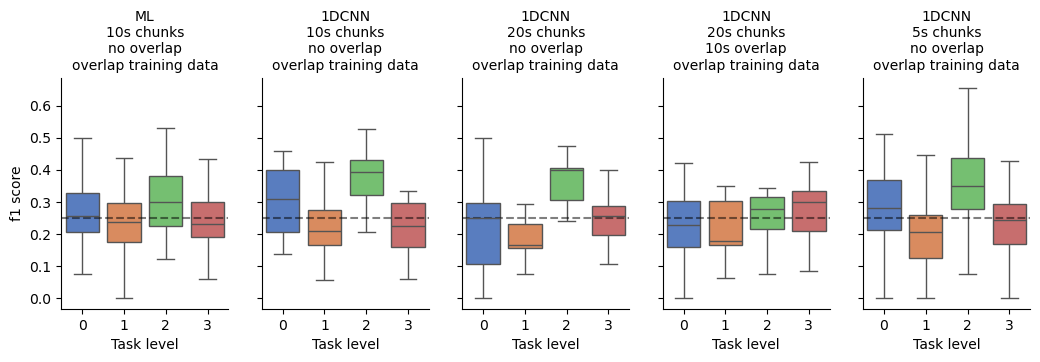

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=5,
                       figsize=(12.5,3),
                       sharey=True)
sns.set_palette('muted')
for col, (folder, df) in enumerate(subject_4class.items()):
    architecture = folder.split('_')[0]
    chunk = folder.split('_')[1]
    overlap = folder.split('_')[3]
    train = folder.split('_')[-1]
    
    sub_groups = df.groupby(df.index.get_level_values(1))
    f1_all = []
    for sub in sub_groups.groups:
        sub_df = sub_groups.get_group(sub)
        f1 = f1_score(sub_df.ytest, sub_df.ypred, average=None)
        f1_all.append(f1)
    sns.boxplot(np.vstack(f1_all), ax=ax[col], showfliers=False)
    ax[col].set_title(f'{architecture}\n{chunk} chunks\n{overlap} overlap\n{train} training data', fontsize=10)
    ax[col].axhline(0.25, ls='--', color='black', alpha=0.5)
    ax[col].spines['top'].set_visible(False)
    ax[col].spines['right'].set_visible(False)
    ax[col].set_ylabel('f1 score') if col == 0 else None
    ax[col].set_xlabel('Task level')
fig.savefig('all_subject_4class.png', bbox_inches='tight')

## Subject-specific models 2-class predictions ##

In [9]:
subject_2class = {}
for folder in ['ML_10s_chunks_no_overlap',
               '1DCNN_10s_chunks_no_overlap',
               '1DCNN_5s_chunks_no_overlap',
               '1DCNN_20s_chunks_10s_overlap']:
    folder_path = os.path.join(subject_dir, folder)
    files = [x for x in os.listdir(folder_path) if ('low_vs_high' in x)]
    folder_predictions = {}
    for f in files:
        subject = ('_').join(f.split('_')[:2])
        
        with open(os.path.join(folder_path, f), 'rb') as file:
            bucket = pickle.load(file) if 'ML' in folder else joblib.load(file)
            
        if 'ML' in f:
            val_scores = np.array([pipe_dict['rcv'].best_score_ for pipe, pipe_dict in bucket.items()])
            best_pipe = list(bucket.keys())[np.argmax(val_scores)]
            predictions = pd.DataFrame([bucket[best_pipe]['best_test']['y_true'].to_numpy(),
                                        bucket[best_pipe]['best_test']['y_pred']
                                       ],
                                        index=['ytest','ypred']).T
        else:
            predictions = pd.DataFrame([bucket['best_test']['y_true'].to_numpy(),
                                        bucket['best_test']['y_pred']
                                       ],
                                        index=['ytest','ypred']).T
        folder_predictions[subject] = predictions
    subject_2class[f'{folder}'] = pd.concat(folder_predictions)

In [11]:
sns.reset_defaults()
fig, ax = plt.subplots(nrows=1, ncols=4,
                       figsize=(8,3),
                       sharey=True)
sns.set_palette('muted')
for col, (folder, df) in enumerate(subject_2class.items()):
    architecture = folder.split('_')[0]
    chunk = folder.split('_')[1]
    overlap = folder.split('_')[3]
    train = folder.split('_')[-1]
    
    sub_groups = df.groupby(df.index.get_level_values(1))
    f1_all = []
    for sub in sub_groups.groups:
        sub_df = sub_groups.get_group(sub)
        f1 = f1_score(sub_df.ytest, sub_df.ypred, average=None)
        f1_all.append(f1)
    sns.boxplot(np.vstack(f1_all), ax=ax[col], showfliers=False)
    ax[col].set_title(f'{architecture}\n{chunk} chunks\n{overlap} overlap\n{train} training data', fontsize=10)
    ax[col].axhline(0.5, ls='--', color='black', alpha=0.5)
    ax[col].spines['top'].set_visible(False)
    ax[col].spines['right'].set_visible(False)
    ax[col].set_ylabel('f1 score') if col == 0 else None
    ax[col].set_xlabel('Task level')
    ax[col].set_xticks([0,1])
    ax[col].set_ylim(0.25,0.85)
    ax[col].set_xticklabels(['Low\n(0 or 1)','High\n(2 or 3)'])
fig.savefig('subject_2class.png', bbox_inches='tight')

## What is the best 4-class model for each subject ##

In [25]:
best_4class = {}
for f in os.listdir(fnirs_data):
    sub = f.split('.csv')[0]
    generic = pd.concat({folder:pd.DataFrame(f1_score(df[df.index.get_level_values(1) == sub].ytest,
                                                      df[df.index.get_level_values(1) == sub].ypred,
                                                      average=None)
                                            ) 
                         for folder, df in generic_4class.items()}
                        , axis=1)
    subject = pd.concat({folder:pd.DataFrame(f1_score(df[df.index.get_level_values(0) == sub].ytest,
                                                      df[df.index.get_level_values(0) == sub].ypred,
                                                      average=None)
                                            ) 
                         for folder, df in subject_4class.items()}
                        , axis=1)
    sub_df = pd.concat([generic, subject], axis=1)
    best_4class[sub] = {sub_df.mean().idxmax()[0]: float(sub_df.mean().max())}

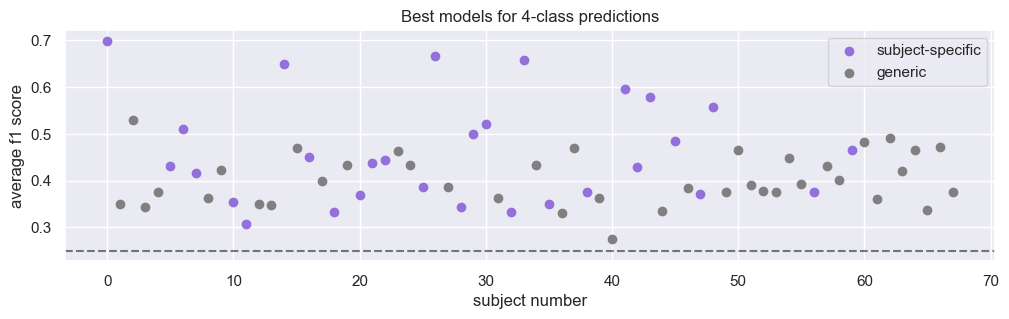

In [29]:
sns.set()
plt.figure(figsize=(12,3))
for x, (sub, sub_dict) in enumerate(best_4class.items()):
    if '%' in list(sub_dict.keys())[0]:
        label = 'generic'
        color = 'grey'
    else:
        label = 'subject-specific'
        color = 'mediumpurple'
    plt.scatter(x,
                [x for x in sub_dict.values()][0],
                color=color,
                label=label
                )
    plt.legend() if x < 2 else None
plt.axhline(0.25, ls='--', color='black', alpha=0.5)
plt.ylabel('average f1 score')
plt.xlabel('subject number')
plt.title('Best models for 4-class predictions');

## What is the best 2-class model for each subject ##

In [30]:
best_2class = {}
for f in os.listdir(fnirs_data):
    sub = f.split('.csv')[0]
    generic = pd.concat({folder:pd.DataFrame(f1_score(df[df.index.get_level_values(1) == sub].ytest,
                                                      df[df.index.get_level_values(1) == sub].ypred,
                                                      average=None)
                                            ) 
                         for folder, df in generic_2class.items()}
                        , axis=1)
    subject = pd.concat({folder:pd.DataFrame(f1_score(df[df.index.get_level_values(0) == sub].ytest,
                                                      df[df.index.get_level_values(0) == sub].ypred,
                                                      average=None)
                                            ) 
                         for folder, df in subject_2class.items()}
                        , axis=1)
    sub_df = pd.concat([generic, subject], axis=1)
    best_2class[sub] = {sub_df.mean().idxmax()[0]: float(sub_df.mean().max())}

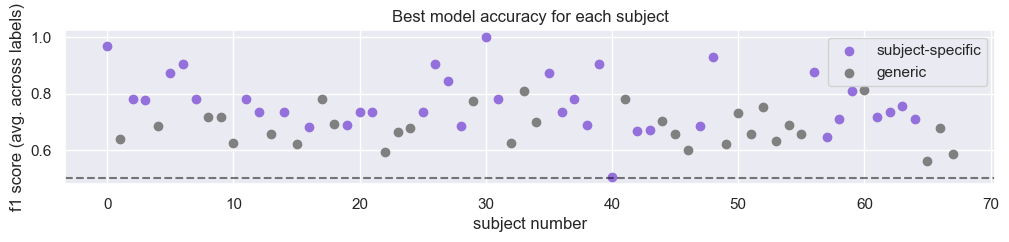

In [41]:
sns.set()
fig = plt.figure(figsize=(12,2))
for x, (sub, sub_dict) in enumerate(best_2class.items()):
    if '%' in list(sub_dict.keys())[0]:
        label = 'generic'
        color = 'grey'
    else:
        label = 'subject-specific'
        color = 'mediumpurple'
    plt.scatter(x,
                [x for x in sub_dict.values()][0],
                color=color,
                label=label
                )
    plt.legend() if x < 2 else None
plt.axhline(0.5, ls='--', color='black', alpha=0.5)
plt.ylabel('f1 score (avg. across labels)')
plt.xlabel('subject number')
plt.title('Best model accuracy for each subject');
fig.savefig('sub_by_sub_best_2class.png', bbox_inches='tight')